### Time Series Analysis on IBM stocks closing prices

### Table of contents:
- <a href='#1'>1.Importing data</a><br/>        
- <a href='#2'>2.Plotting the data</a>
- <a href='#3'>3.Check Stationarity</a>
- <a href='#4'>4.Log Transformation</a>
- <a href='#5'>5.Exponentially weighted moving average</a>
- <a href='#6'>6.Eliminating Trend and Seasonality</a>
- <a href='#7'>7.ACF and PACF plots</a>
- <a href='#8'>8.Algorithm Selection</a>
  - <a href='#8.1'> AR Model</a>
  - <a href='#8.2'> MA Model</a>
  - <a href='#8.3'> ARIMA Model</a>

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [118]:
data = pd.read_csv("ibm-common-stock-closing-prices.csv")

In [119]:
data.head()

,Date,IBM common stock closing prices
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


Top 6 rows of data

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 2 columns):
Date                               1009 non-null object
IBM common stock closing prices    1008 non-null float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


**Observations:**<br/>
No of rows: 1008<br/>
No.of columns: 2<br/>

In [121]:
data.describe()

,IBM common stock closing prices
count,1008.000000
mean,462.817688
std,60.441924
min,306.000000
25%,420.437500
50%,460.625000
75%,500.750000
max,598.500000


**Missing values if any**

In [122]:
data.isnull().sum()

Date                               0
IBM common stock closing prices    1
dtype: int64

In [123]:
data.dropna(inplace=True)
print(data.dtypes)

Date                                object
IBM common stock closing prices    float64
dtype: object


**Observations:** But this is still not read as a TS object as the data types are ‘object’ and ‘float’. In order to read the data as a time series, we have to parse the date column.

**Using to_datetime**

In [124]:
data['Date'] = pd.to_datetime(data['Date'])

In [125]:
t=data.set_index(data.Date)
del t['Date']
t.index

DatetimeIndex(['1962-01-02', '1962-01-03', '1962-01-04', '1962-01-05',
               '1962-01-08', '1962-01-09', '1962-01-10', '1962-01-11',
               '1962-01-12', '1962-01-15',
               ...
               '1965-12-17', '1965-12-20', '1965-12-21', '1965-12-22',
               '1965-12-23', '1965-12-27', '1965-12-28', '1965-12-29',
               '1965-12-30', '1965-12-31'],
              dtype='datetime64[ns]', name='Date', length=1008, freq=None)

**Observations:**  Notice the dtype=’datetime[ns]’ which confirms that it is a datetime object. 

In [126]:
ts = t['IBM common stock closing prices'] 
ts.head()

Date
1962-01-02    572.00
1962-01-03    577.00
1962-01-04    571.25
1962-01-05    560.00
1962-01-08    549.50
Name: IBM common stock closing prices, dtype: float64

**Note:** Now we can see that the data has time object as index and closing prices as column. 

### <a id='2'>**Simply plot the data and analyze visually** </a>

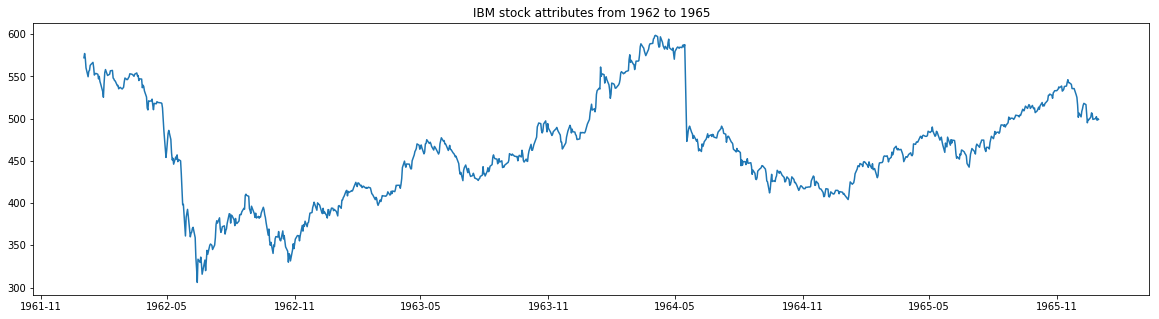

In [127]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
plt.plot(ts)
plt.title('IBM stock attributes from 1962 to 1965')
pyplot.show()

**Observations:**<br/>
From the above plot, it is clear that there is an increasing trend till 1964-05 and then sudden dip and again graph started increasing gradually. Lets investigate further.

### Stationary

*A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time.*<br/>

<p align="center">
<img src="Mean_nonstationary.png" alt="neofetch" align="middle" width="500px">
</p>

<p align="center">
<img src="Var_nonstationary.png" alt="neofetch" align="middle" width="500px">
</p>

**But why is it important?** <br/>
Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can say that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 

*There are three basic criterion for a series to be classified as stationary series :* 

1. Constant mean
2. Constant variance
3. an autocovariance that does not depend on time.

**Why do I care about ‘stationarity’ of a time series?**<br/>
The reason is that until unless your time series is stationary, you cannot build a time series model. In cases where the stationary criterion are violated, the first requisite becomes to stationarize the time series and then try models to predict this time series. 

### <a id='3'> **Check Stationarity of time series** </a>

Stationary testing and converting a series into a stationary series are the most critical processes in a time series modelling.

**Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

**Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. 

1. *Null hypothesis is that the TS is non-stationary.* <br/>
2. *The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.* <br/>
3. *If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.*

In [128]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    from matplotlib import pyplot
    plt.figure(figsize=(20,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.figure(figsize=(20,5))
    pyplot.show(block=False)
    
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

**Note:** I have defined a function to use rolling statistics plots along with Dickey-Fuller test results to check stationarity.

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


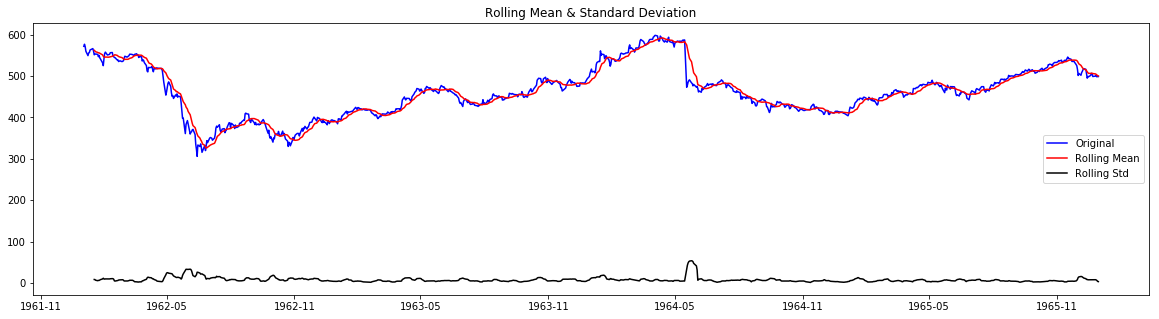

Results of Dickey-Fuller Test:
Test Statistic                   -2.171887
p-value                           0.216606
#Lags Used                        0.000000
Number of Observations Used    1007.000000
Critical Value (1%)              -3.436860
Critical Value (5%)              -2.864414
Critical Value (10%)             -2.568300
dtype: float64


In [129]:
test_stationarity(ts)

**Observations:**<br/>
Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is more than the critical values. p-value also greater than threshold(0.05). Accept null hypothesis.

### <a id='3'> **How to make a Time Series Stationary?** </a>

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationarity of a TS:
1. **Trend** – varying mean over time. 
2. **Seasonality** – variations at specific time-frames.

*The main principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series.* 

**One of the first ways to reduce trend can be transformation**. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc.

### <a id='4'> Log transformation </a>

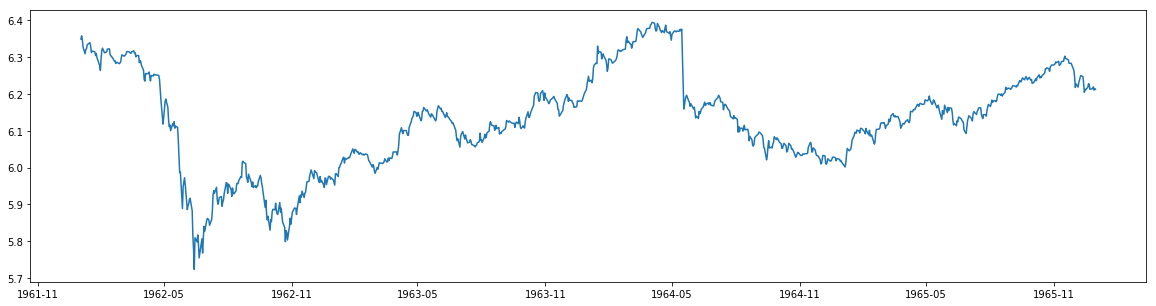

In [130]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
ts_log = np.log(ts)
plt.plot(ts_log)
pyplot.show()

**Note:** It is not easy to see a trend in the data, in presence of noise. So we can use smoothing techniques(taking rolling averages) to estimate or model this trend and then remove it from the series.

*Smoothing refers to taking rolling estimates, i.e. considering the past few instances.*
1. Simple Moving average
2. Weighted Moving average
3. Exponential smoothing

### <a id='5'> Simple Moving Average </a><br/>

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values.

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  


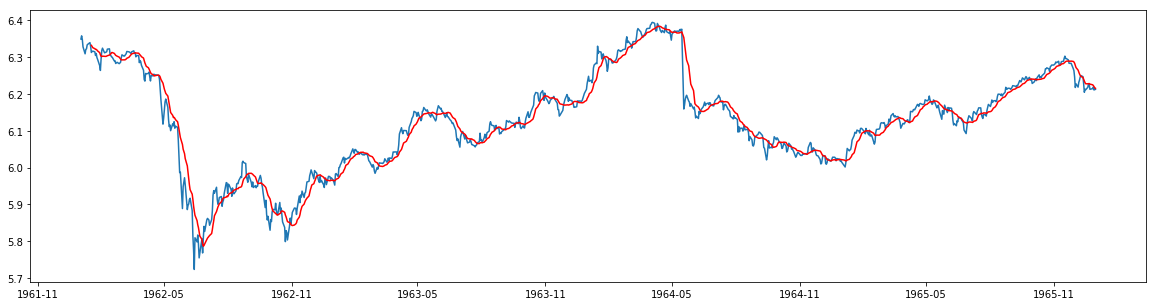

In [131]:
plt.figure(figsize=(20,5))
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
pyplot.show()

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


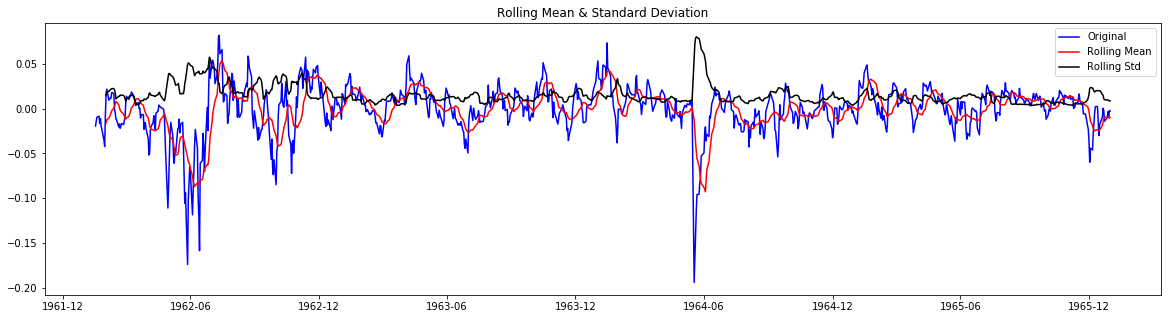

Results of Dickey-Fuller Test:
Test Statistic                -5.835866e+00
p-value                        3.877986e-07
#Lags Used                     1.700000e+01
Number of Observations Used    9.790000e+02
Critical Value (1%)           -3.437047e+00
Critical Value (5%)           -2.864497e+00
Critical Value (10%)          -2.568344e+00
dtype: float64


In [132]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12) #Notice the first 11 being Nan. Lets drop these NaN values and check the plots to test stationarity.
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

**Observations:** Reject Null Hypothesis.. Time Series is stationary.

However, a drawback in this particular approach is that the *time-period has to be strictly defined*. In this case we can take yearly averages but in *complex situations like forecasting a stock price, its difficult to come up with a number*. So we take a **‘weighted moving average’ where more recent values are given a higher weight.** There can be many technique for assigning weights. **A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.** Find details here. This can be implemented in Pandas as:

### <a id='5'> Exponentially weighted moving average </a><br/>
Weights are assigned to all the previous values with a decay factor.

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


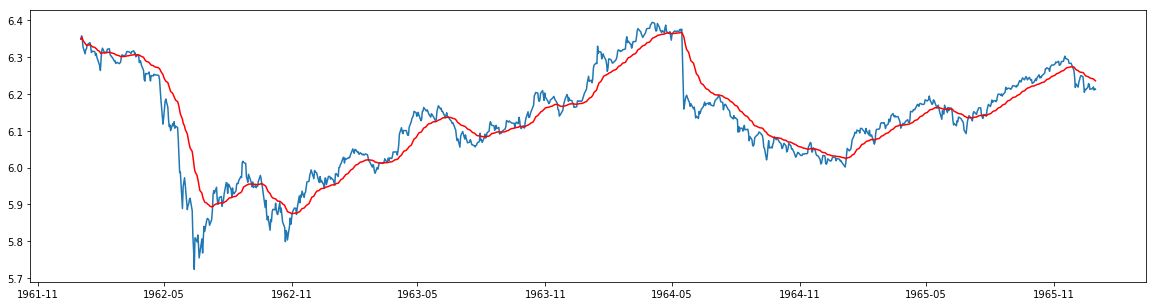

In [133]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
pyplot.show()

**Note:** the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay . Lets remove this from series and check stationarity:

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


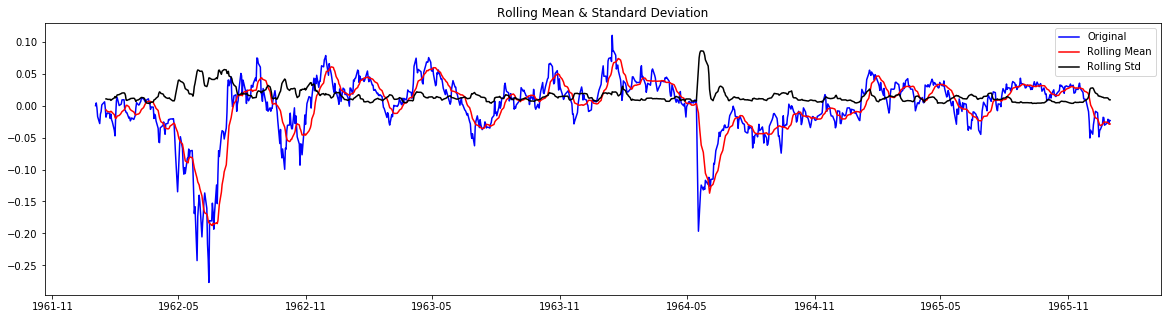

Results of Dickey-Fuller Test:
Test Statistic                  -4.540785
p-value                          0.000166
#Lags Used                      17.000000
Number of Observations Used    990.000000
Critical Value (1%)             -3.436973
Critical Value (5%)             -2.864464
Critical Value (10%)            -2.568327
dtype: float64


In [134]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

**Observations:**<br/>
This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the critical value, p-value is less than 0.05,  reject null hypothesis. TS is stationary now.

### <a id='6'> Eliminating Trend and Seasonality </a>

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality.<br/> 
Lets discuss aonther way of removing trend and seasonality:<br/>
*1. Differencing* – taking the differece with a particular time lag<br/>
*2. Decomposition* - modeling both trend and seasonality and removing them from the model.<br/>

**Differencing**

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity.

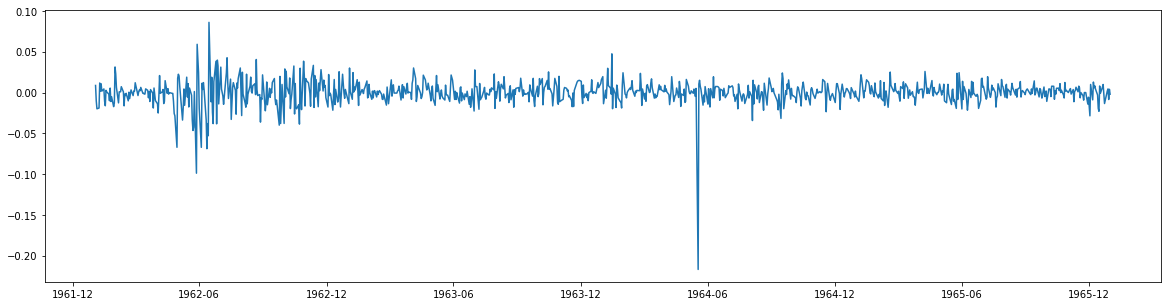

In [135]:
from matplotlib import pyplot
plt.figure(figsize=(20,5))
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

This appears to have reduced trend considerably. Lets verify using our plots:

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


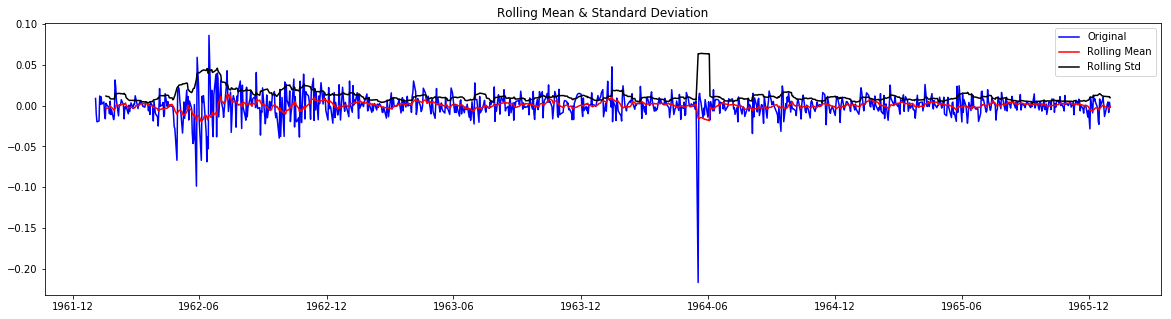

Results of Dickey-Fuller Test:
Test Statistic                -5.914021e+00
p-value                        2.598360e-07
#Lags Used                     1.600000e+01
Number of Observations Used    9.900000e+02
Critical Value (1%)           -3.436973e+00
Critical Value (5%)           -2.864464e+00
Critical Value (10%)          -2.568327e+00
dtype: float64


In [136]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

**Observations:** We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence. 

**Decomposition**

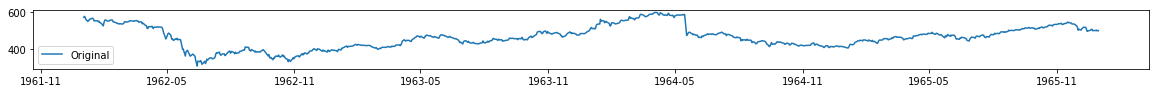

In [137]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(20,5))
decomposition = seasonal_decompose(ts_log, model = 'additive', freq = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
pyplot.show()

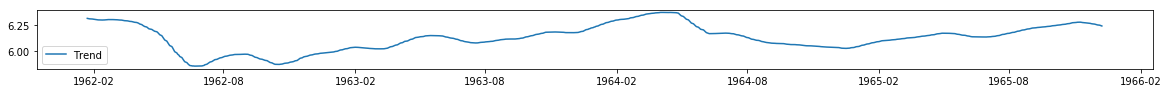

In [138]:
plt.figure(figsize=(20,5))
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
pyplot.show()

**Observations:** if you see the above graph, there is a cyclic trend.

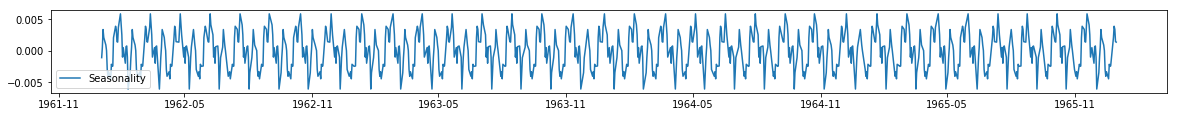

In [139]:
plt.figure(figsize=(20,7))
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
pyplot.show()

**Observations:** There is no seasonality

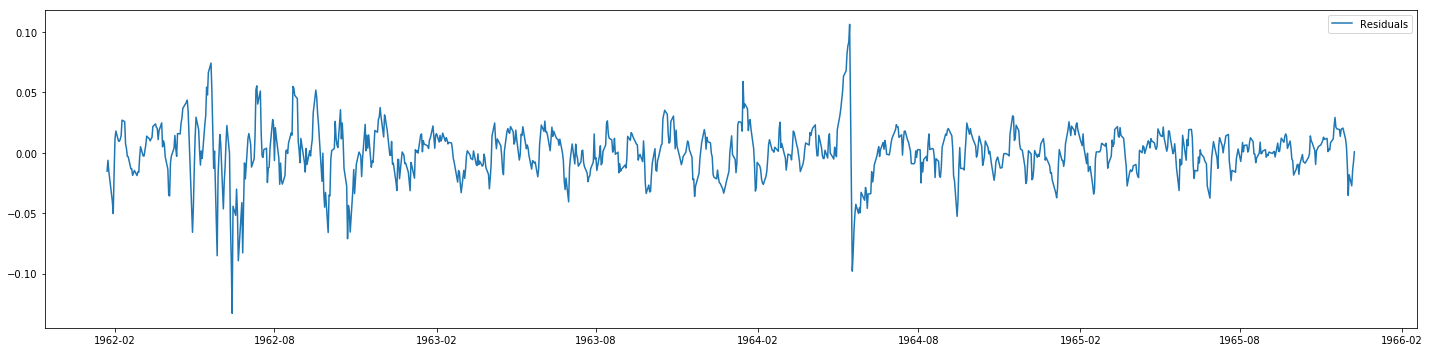

In [140]:
plt.figure(figsize=(20,5))
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
pyplot.show()

**Lets remove trend from the data**

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  
C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  import sys


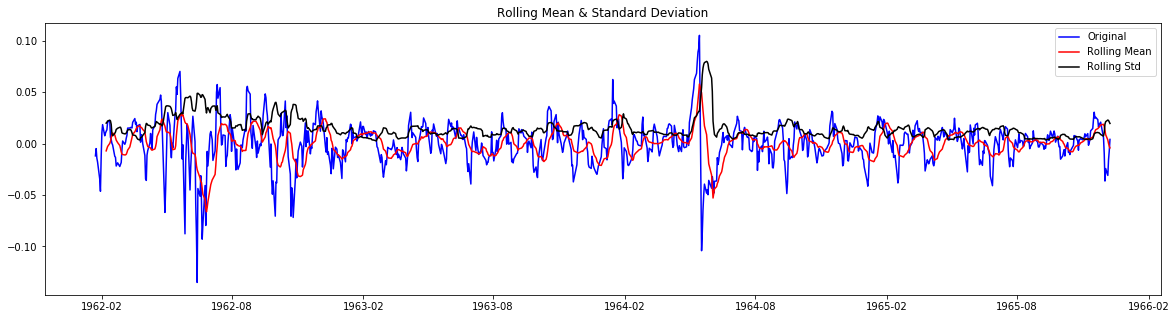

Results of Dickey-Fuller Test:
Test Statistic                -8.450984e+00
p-value                        1.662690e-13
#Lags Used                     2.000000e+01
Number of Observations Used    9.570000e+02
Critical Value (1%)           -3.437202e+00
Critical Value (5%)           -2.864565e+00
Critical Value (10%)          -2.568381e+00
dtype: float64


In [141]:
ts_log_decompose = ts_log - trend
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

**Observations**<br/>
The Dickey-Fuller test statistic is very significantly lower than the 5% critical value. Also p-value is less than threshold(0.05). Reject null hypothesis and proves that TS is stationary.

**Now the time series is stationary and there is no trend or seasonality. Lets decompose this series again and visualize the same**

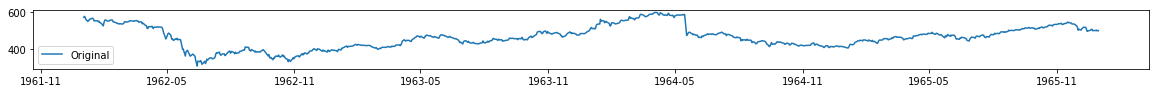

In [142]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(20,5))
decomposition1 = seasonal_decompose(ts_log_decompose, model = 'additive', freq = 30)

trend1 = decomposition1.trend
seasonal1 = decomposition1.seasonal
residual1 = decomposition1.resid

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
pyplot.show()

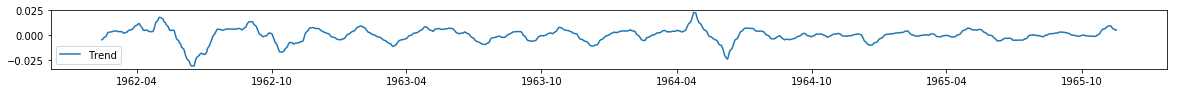

In [143]:
plt.figure(figsize=(20,5))
plt.subplot(412)
plt.plot(trend1, label='Trend')
plt.legend(loc='best')
pyplot.show()

**Note: If you notice clearly, there is no trend in this timeseries as we have already removed it**

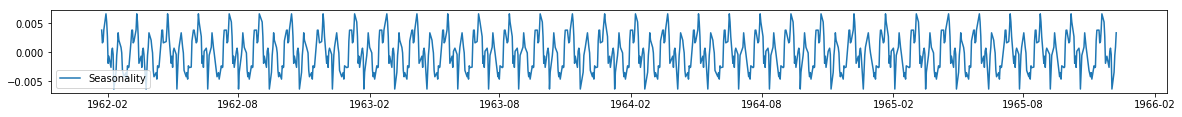

In [144]:
plt.figure(figsize=(20,7))
plt.subplot(413)
plt.plot(seasonal1,label='Seasonality')
plt.legend(loc='best')
pyplot.show()

**Forecasting Time Series**

**ARIMA**

ARIMA stands for **Auto-Regressive Integrated Moving Averages**. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters **(p,d,q) of the ARIMA model**:

**Number of AR (Auto-Regressive) terms (p):** AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).<br/>

**Number of MA (Moving Average) terms (q):** MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.<br/>

**Number of Differences (d):** These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.<br/>

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

### <a id='7'> ACF and PACF plots </a>

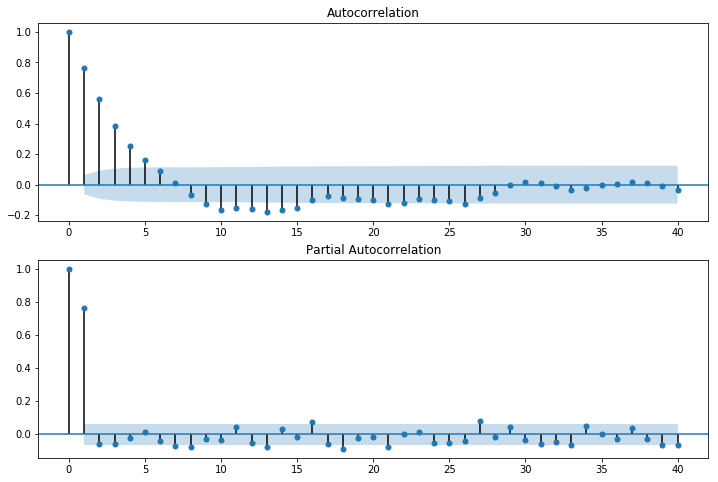

In [146]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_decompose.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_decompose, lags=40, ax=ax2)
plt.show()

**Observations:**<br/>
In the above two plots, the blue shaded area on the either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values.<br/>
p – The lag value where the PACF chart crosses the upper confidence interval. If you notice closely, in this case p=1.<br/>
q – The lag value crosses the upper confidence interval. q=4.<br/>

### <a id='8'> Algorithm Selection </a>

**AR Model**


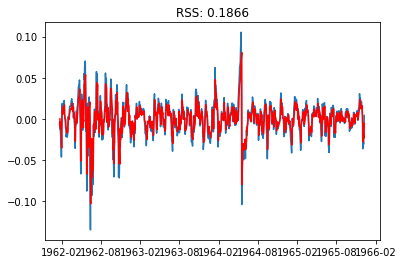

In [154]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log_decompose, order=(1, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_decompose)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_decompose)**2))
pyplot.show()

**MA Model**

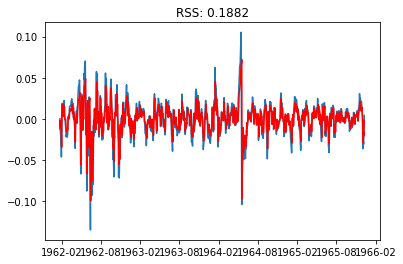

In [158]:
model1 = ARIMA(ts_log_decompose, order=(0, 0, 4))  
results_MA = model1.fit(disp=-1)  
plt.plot(ts_log_decompose)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_decompose)**2))
pyplot.show()

**ARIMA Model**

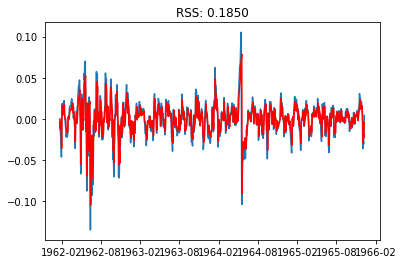

In [160]:
model = ARIMA(ts_log_decompose, order=(1, 0, 4))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_decompose)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_decompose)**2))
pyplot.show()

**Taking it back to original scale**<br/>
Here we can see that the AR and MA models have almost the same RSS(Residual Sum Squares). Since the combined model gave best result, lets scale it back to the original values and see how well it performs there. 

In [161]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Date
1962-01-23   -0.000025
1962-01-24   -0.009131
1962-01-25   -0.003229
1962-01-26   -0.010638
1962-01-29   -0.013922
dtype: float64

Store the predicted results as a separate series and observe it. 

**Observations:**<br/>
Notice that these start from ‘1962-01-23’ and not from the first. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number.

In [162]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Date
1962-01-23   -0.000025
1962-01-24   -0.009156
1962-01-25   -0.012384
1962-01-26   -0.023022
1962-01-29   -0.036945
dtype: float64

Determined cumulative sum. Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. Here the first element is base number itself and from thereon the values cumulatively added.

In [163]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\welcome\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Date
1962-01-02    6.349139
1962-01-03    6.349139
1962-01-04    6.349139
1962-01-05    6.349139
1962-01-08    6.349139
dtype: float64

Final step is to take the exponent and compare with the original series.

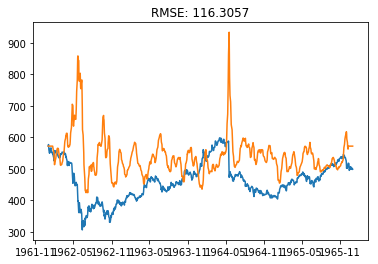

In [164]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))
pyplot.show()

**Conclusions:**
Finally we have a forecast at the original scale. I have tried to give a standard approach for solving time series problem by covering concepts of stationarity, how to take a time series closer to stationarity and finally forecasting.